# Stellar color (B-I)

In [1]:
import pynbody
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pynbody.plot.stars import convert_to_mag_arcsec2
from pynbody.derived import lum_den_template

In [2]:
snap = "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"

In [3]:
s = pynbody.load(snap)

In [4]:
pynbody.analysis.halo.center(s.g, vel=False);

In [5]:
mags = pynbody.analysis.luminosity.calc_mags(s.s)
mags.shape, mags.units

((140168,), NoUnit())

In [6]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from pynbody.plot.stars import convert_to_mag_arcsec2
from pynbody.derived import lum_den_template
from scipy.ndimage.filters import gaussian_filter

def kpc2pix(qty_kpc, width, resolution):
    kpc_per_pixel = width/resolution
    return int(np.floor(qty_kpc/kpc_per_pixel))

def my_convert_to_mag_arcsec2(image):
    assert image.units=="pc^-2"
    pc2_to_sqarcsec = 2.3504430539466191e-09
    img_mag_arcsec2 = -2.5 * np.log10(image * pc2_to_sqarcsec)
    img_mag_arcsec2.units = pynbody.units.arcsec**-2
    return img_mag_arcsec2

def color_plot(snap, bands=('b','i'), width=10, resolution=500, mag_filter=29, 
               center=False, title=None, gaussian_sigma=None, cmap_name='seismic', **kwargs):
    """
    Plot the color as defined by the tuple `bands`
    
    Parameters
    ----------

    gaussian_sigma: in kpc is the sigma of the gaussian to convolve with the image, to make it more realistic
    
    mag_filter: all region with magnitude/arcsec^2 higher will be set to NaN
    """
    if center:
        pynbody.analysis.halo.center(snap.s, vel=False);
    
    # create color
    assert len(bands) == 2
    color_name = '{}-{}'.format(*bands)
    snap.s['{}_mag'.format(color_name)] = snap.s['{}_mag'.format(bands[0])] - snap.s['{}_mag'.format(bands[1])]    
    snap.s['{}_lum_den'.format(color_name)] = lum_den_template(color_name, snap.s)
    
    # plot color in 10^(-0.4) mag per unit surface
    color_pc2 = pynbody.plot.sph.image(snap.s, qty=color_name + '_lum_den', units='pc^-2', noplot=True, width=width, log=False, resolution=resolution, **kwargs)
    
    # convert to mag/arcsec**2
    color_mag_arcsec2 = my_convert_to_mag_arcsec2(color_pc2)
    
    if gaussian_sigma is not None:
        sigma_pix = kpc2pix(gaussian_sigma, width, resolution)
        color_mag_arcsec2 = gaussian_filter(color_mag_arcsec2, sigma_pix)
        
    # Filter below a certain magnitude
    if mag_filter is not None:
        color_mag_arcsec2[color_mag_arcsec2 > mag_filter] = np.nan
    fig, ax = plt.subplots(1)
    cmap = plt.get_cmap(cmap_name)
    cmap.set_bad('black')
    img = ax.imshow(color_mag_arcsec2, cmap=cmap, extent=(-width/2, width/2, -width/2, width/2))
    cbar = fig.colorbar(img);
    ax.set_xlabel('x/kpc')
    ax.set_ylabel('y/kpc')
    if title is not None:
        ax.set_title(title)
    cbar.set_label('{} [mag/arcsec$^2$]'.format(color_name.upper()));
    plt.show()

In [7]:
s.properties['boxsize'] = pynbody.units.Unit("1000 Gpc")

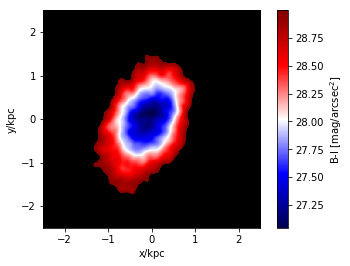

In [8]:
color_plot(s, width=5, bands=('b', 'i'), gaussian_sigma=0.05)

# Test step by step

In [9]:
width = 6
resolution = 500

luminosity density is in unit: 10^(-0.4) mag per unit volume, and it is defined as:

```
val = (10 ** (-0.4 * s[band + "_mag"])) * s['rho'] / s['mass']
val.units = s['rho'].units/s['mass'].units
return val
```

To use `lum_den` it is needed to end the magnitude with mag.

In [10]:
s.s['b-i_mag'] = s.s['b_mag'] - s.s['i_mag']

In [11]:
s.s['b-i_mag']

SimArray([1.64398415, 1.64407435, 1.64217338, ..., 1.63853817, 1.63850947,
          1.64663266])

In [12]:
s.s['b-i_lum_den'] = lum_den_template('b-i', s.s)
s.s['b-i_lum_den']

SimArray([9.82393057e-10, 2.53433266e-09, 1.63902388e-07, ...,
          1.19745574e-10, 1.06338103e-10, 5.03714928e-11], 'kpc**-3')

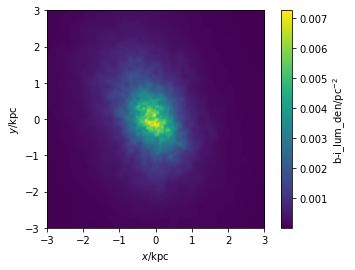

In [13]:
bmi_pc2 = pynbody.plot.sph.image(s.s, qty='b-i_lum_den', units='pc^-2', width=width, log=False, resolution=resolution)

In [14]:
bmi_pc2

SimArray([[2.9201803e-05, 2.9403289e-05, 2.9604777e-05, ...,
           3.8509133e-05, 3.8298916e-05, 3.8088700e-05],
          [2.9257153e-05, 2.9455619e-05, 2.9654086e-05, ...,
           3.8435901e-05, 3.8227237e-05, 3.8018574e-05],
          [2.9312501e-05, 2.9507948e-05, 2.9703398e-05, ...,
           3.8362672e-05, 3.8155555e-05, 3.7948445e-05],
          ...,
          [6.5602399e-05, 6.6646549e-05, 6.7690700e-05, ...,
           1.9262869e-05, 1.9048828e-05, 1.8834793e-05],
          [6.5390697e-05, 6.6436151e-05, 6.7481596e-05, ...,
           1.9257650e-05, 1.9046380e-05, 1.8835110e-05],
          [6.5178989e-05, 6.6225744e-05, 6.7272493e-05, ...,
           1.9252431e-05, 1.9043928e-05, 1.8835426e-05]], dtype=float32, 'pc**-2')

In [15]:
def my_convert_to_mag_arcsec2(image):
    assert image.units=="pc^-2"
    pc2_to_sqarcsec = 2.3504430539466191e-09
    img_mag_arcsec2 = -2.5 * np.log10(image * pc2_to_sqarcsec)
    img_mag_arcsec2.units = pynbody.units.arcsec**-2
    return img_mag_arcsec2

In [16]:
pynbody.units.pc/pynbody.units.arcsec

Unit("pc arcsec**-1")

In [17]:
# s.s['bmi_mag_arcsec2'] = my_convert_to_mag_arcsec2(bmi_pc2)
bmi_mag_arcsec2 = my_convert_to_mag_arcsec2(bmi_pc2)
bmi_mag_arcsec2

SimArray([[32.9086  , 32.90114 , 32.893723, ..., 32.608215, 32.61416 ,
           32.620132],
          [32.906548, 32.899204, 32.891914, ..., 32.610283, 32.61619 ,
           32.62214 ],
          [32.904495, 32.897278, 32.89011 , ..., 32.612354, 32.618233,
           32.624138],
          ...,
          [32.029827, 32.01268 , 31.995804, ..., 33.360325, 33.372456,
           33.384724],
          [32.033337, 32.016113, 31.99916 , ..., 33.36062 , 33.372597,
           33.384705],
          [32.036858, 32.019558, 32.002533, ..., 33.360912, 33.372734,
           33.38469 ]], dtype=float32, 'arcsec**-2')

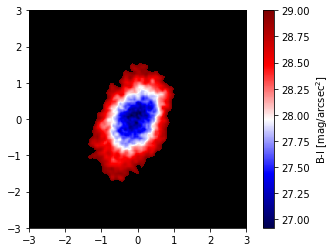

In [18]:
bmi_mag_arcsec2[bmi_mag_arcsec2 > 29] = np.nan
fig, ax = plt.subplots(1)
cmap = matplotlib.cm.seismic
cmap.set_bad('black')
img = ax.imshow(bmi_mag_arcsec2, cmap=cmap, extent=(-width/2, width/2, -width/2, width/2))
cbar = fig.colorbar(img);

cbar.set_label('B-I [mag/arcsec$^2$]');

# Try with a real simulation

In [19]:
import simulation

In [20]:
SIMPATH = '/media/michele/My Book/Michele/MySimulations/MovingBox/hi_osc/mb.71002_p500_a800_r600/out'

In [21]:
sim = simulation.Simulation(SIMPATH)

loading simulation: /media/michele/My Book/Michele/MySimulations/MovingBox/hi_osc/mb.71002_p500_a800_r600/out
Found parameter file
Found compiler file
Loading cosmological parameters
Found trace file


In [22]:
import ipywidgets

snap_slider = ipywidgets.IntSlider(min=0,max=len(sim)-1,step=1,value=0, continuous_update=False, description='Snap:')

def k(i):
    snap = sim[i]
    print(len(snap.s))
    color_plot(snap, width=20, title='{:.2f}'.format(snap.header.time), center=True, mag_filter=32)

w = ipywidgets.interactive(k, i=snap_slider)
w

interactive(children=(IntSlider(value=0, continuous_update=False, description='Snap:', max=562), Output()), _d…